18000 18000 1000.0 9.240362641715905e-11
g2(0) = 0.61


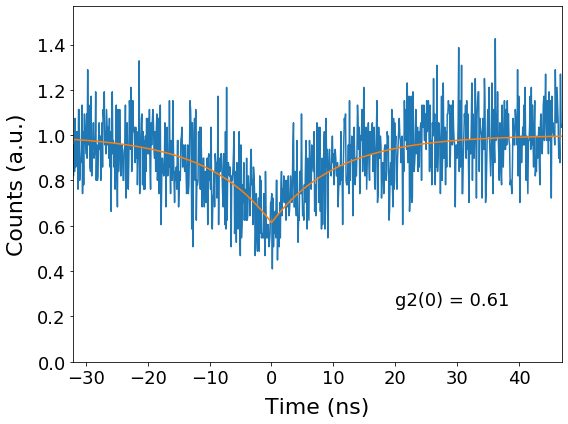

In [23]:
import sys
sys.path.append("..")
#import matplotlib
#%matplotlib inline
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import numpy as np
from LowLevelModules.ImportSDT import SdtFile
from LowLevelModules.GeneralFunctions import get_work_dir, prettify_plot
#"Z:\Projects\Boron Nitride\Data\TimeCorrelation\20190409_hBN_nf_LJ1_3D_1.sdt"

file = r"Z:\Projects\WSe2\2019\11 november\2019-11-15 hBNWSe2 gatedNP3\5K data\hBNWSe2_gatedNP3_5K_40nW_QD3_-3V"
sdt = SdtFile(file + '.sdt')
delay = -40.98
times = sdt.times[0]
info = sdt.measure_info[0]
x = times*1e9 + delay
y = sdt.data[0][0]
dt_bin= (times[-1]-times[0])/(len(times)-1)
col_t = info['col_t'][0]

#trim data
x = x[y>0]
y = y[y>0]

#ct_rate1
info_ctr = info['StopInfo']
min_ctr11 = info_ctr['min_sync_rate'][0]
min_ctr12 = info_ctr['min_cfd_rate'][0]
min_ctr13 = info_ctr['min_tac_rate'][0]
max_ctr11 = info_ctr['max_sync_rate'][0]
max_ctr12 = info_ctr['max_cfd_rate'][0]
max_ctr13 = info_ctr['max_tac_rate'][0]

Ct_rate_APD1 = (min_ctr12 + max_ctr12) / 2
Ct_rate_APD2 = (min_ctr11 + max_ctr11) / 2
Ct_rate_APD1 = 18*1000
Ct_rate_APD2 = 18*1000
print(Ct_rate_APD1, Ct_rate_APD2, col_t, dt_bin)
#normalization
norm = float(Ct_rate_APD1 * Ct_rate_APD2 * dt_bin * col_t)
#norm = float(max_ctr11 * max_ctr12 * dt_bin * col_t)

y = np.divide(y, np.mean(y[656:]), casting="unsafe")
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.plot(x, y)

# fitting the data
# def g2(t, I0, t0, t1, t2):
#     return I0*(t2-np.exp(-abs(t-t0)/t1))/t2

def g2(t, tau, N):
    return (N-1)/N + 1/N*(1-np.exp(-abs(t)/tau))

coeffs, pcov = curve_fit(g2, x, y)
perr = np.sqrt(np.diag(pcov))
y_arrf = g2(x, *coeffs)
ax.plot(x, y_arrf)

prettify_plot(ax, "Time (ns)", "Counts (a.u.)")
ax.set_xlim([np.min(x), np.max(x)])
ax.set_ylim([0, 1.1*np.max(y)])
ax.text(20, 0.25, f"g2(0) = {np.round(1-1/coeffs[1], 2)}", fontsize=18)
plt.tight_layout()
print(f"g2(0) = {np.round(1-1/coeffs[1], 2)}")

In [17]:
fig.savefig(file + '.png', format='png', bbox_inches='tight')

In [31]:
info_ctr = info['StopInfo']['min_sync_rate']

In [16]:
info['col_t']

array([1200.], dtype=float32)

In [18]:
coeffs

array([4.06722585, 1.40839274])

In [9]:
len(x)

856